# Online Convex Optimization

Данные будем брать из этого датасета:
https://archive.ics.uci.edu/ml/datasets/spambase

In [229]:
# подключение необходимых библиотек

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cvx
%matplotlib inline

In [230]:
spam_data = pd.read_csv('spambase.data', header=None)

d = 55
spam_data.columns = np.arange(0, 58)
print(d)
spam_data.head()

55


,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


Заметим, что в данном датасете сначала идут те сообщения, которые являются спамом, а потом - те, которые не являются. Это может негативно сказаться на качестве работы алгоритмов. Поэтому сделаем `shuffle` строк датасета при помощи функции `pandas.sample`.

In [231]:
spam_data = spam_data.sample(frac=1)
spad_data = pd.DataFrame(spam_data.values, columns=spam_data.columns)
spam_data.head(10)

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
2519,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.000,0.000,0.0,0.000,0.000,0.000,3.125,17,25,0
1937,0.00,0.0,0.35,0.0,0.35,0.71,0.00,0.00,0.00,0.00,...,0.000,0.124,0.0,0.372,0.000,0.000,1.641,12,110,0
874,0.00,0.0,0.44,0.0,0.88,0.22,0.00,0.00,0.00,0.00,...,0.037,0.224,0.0,0.000,0.187,0.149,3.384,21,264,1
1043,0.00,0.0,0.09,0.0,0.58,0.29,0.09,0.00,0.38,0.00,...,0.063,0.047,0.0,0.559,0.047,0.031,1.694,23,432,1
4178,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.86,...,0.000,0.321,0.0,0.214,0.000,0.000,3.956,51,91,0
1000,0.45,0.9,0.90,0.0,0.45,0.00,0.00,0.45,0.00,1.80,...,0.000,0.244,0.0,1.631,0.244,0.081,64.416,708,773,1
2466,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.000,0.000,0.0,0.000,0.000,0.000,1.785,6,25,0
3665,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.000,0.000,0.0,0.000,0.000,0.000,1.000,1,3,0
3033,0.00,0.0,2.04,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.000,0.000,0.0,0.000,0.000,0.000,1.428,3,20,0
720,0.32,0.0,1.64,0.0,0.98,0.00,0.32,0.00,0.65,1.31,...,0.000,0.000,0.0,0.858,0.101,0.000,337.250,1146,1349,1


Для дальнейшего применения алгоритмов разобьём данные на значения признаков и столбец целевой переменной.

In [232]:
X = spam_data[np.arange(d)].values
y = spam_data[57].values

### Online Gradient Descent

Для начала, чтобы убедиться в адекватности построенной модели, применим online градиентный спуск.
Запустим его на разных начальных приближениях.

**Замечание.**

Для получения значений `regret`ов был использован пакет для выпуклой оптимизации `cvxpy`, который получает ответ достаточно медленно. По этой причине я считал эти значения не на всех итерациях алгоритма.

Чтобы не считать значения `regret`, можно не передавать 3 параметр в функцию `online_gradient_descent`.

In [261]:
R = 1.0
G = 1.3
D = 2.0 * R

M = 100.0*R

#объявление необходимых функций

def proection(x):
    if np.linalg.norm(x) <= R:
        return x
    return x / np.linalg.norm(x) * R

def grad(x, w, y_value):
    return (np.dot(x, w) + M - 2.0 * M * y_value) / (2.0*M**2) * w

def calc_opt_value(x_list, y_list):
    w = cvx.Variable(d)
    #print(x_list)
    #print(y_list)
    prob = cvx.Problem(cvx.Minimize(cvx.sum_squares(y_list - (x_list*w + M) / (2*M))), 
                       [cvx.sum_squares(w) <= R**2])

    result = prob.solve(solver=cvx.SCS, verbose=False, eps=0.01)
    return result

def calc_regret(cur_sum, x_list, y_list):
    return cur_sum - calc_opt_value(x_list, y_list)

def online_gradient_descent(x0, T, regrets=None, param_G=G, param_D=D, step_search=None):
    x = x0
    t = 1
    cur_sum = 0
    x_list = []
    accuracy = 0
    
    if step_search is None:
        get_step = lambda x_value, h, f, gradf, it: param_D / (param_G * float(it)**0.5)
    else:
        get_step = lambda x_value, h, f, gradf, it: step_search(x_value, h, f, gradf)
    while t <= T:
        cur_grad = grad(x, X[t - 1], y[t - 1])
        alpha = get_step(x, cur_grad, 
                         lambda z: (y[t - 1] - (np.dot(X[t - 1], x) + M) / (2*M))**2,
                         lambda z: grad(z, X[t - 1], y[t - 1]), t)
        new_x = proection(x - alpha * cur_grad)
        
        x = new_x
        x_list.append(x)
        cur_dot = np.dot(X[t - 1], x)
        if (np.sign(cur_dot) + 1)*0.5 == y[t - 1]:
            accuracy += 1
        
        cur_sum += (y[t - 1] - (cur_dot + M) / (2*M))**2
        if not (regrets is None) and ((t == T) or (t % 500 == 0)):
            regrets.append((t, calc_regret(cur_sum, np.array(x_list), y[:t])))
        t += 1
    accuracy /= float(T)
    print("accuracy:", accuracy)
    return x_list

In [ ]:
def try_online_gd(x0):
    regrets = []
    a = online_gradient_descent(x0, len(spam_data), regrets)
    dots = np.dot(X, a)
    predict = (np.sign(dots) + 1.0) / 2
    regrets = np.array(regrets)

    success = len(predict[predict == y])
    print('regrets: ', regrets[:, 1])
    return (regrets[:, 0], regrets[:, 1])
    
regret_matr = []
regret_matr.append(try_online_gd(np.zeros(d)))
regret_matr.append(try_online_gd(np.ones(d) * R / (float(d)**0.5)))
regret_matr.append(try_online_gd(np.hstack(([R], np.zeros(d - 1)))))

Построим графики посчитанных значений $regret$ в каждом случае.

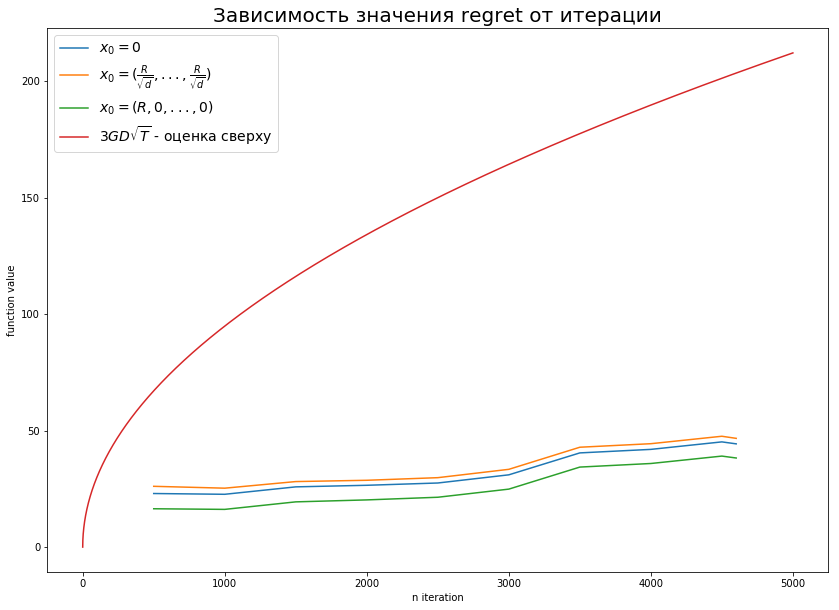

In [170]:
def plot_gd_regrets(regrets, labels=['$x_0=0$', 
                                  '$x_0=(\\frac{R}{\\sqrt{d}}, ..., \\frac{R}{\\sqrt{d}})$',
                                  '$x_0=(R, 0, ..., 0)$']):
    plt.figure(figsize=(14, 10))
    for (regret, label) in zip(regrets, labels):
        plt.plot(regret[0], regret[1], label=label)
        
    grid = np.linspace(0, 5000, 100000)
    plt.plot(grid, 3.0*D*G*(grid**0.5), label=u'$3GD\\sqrt{T}$ - оценка сверху')
        
    plt.legend(fontsize=14)
    plt.title(u'Зависимость значения regret от итерации', fontsize=20)
    plt.xlabel('n iteration')
    plt.ylabel('function value')
    plt.show()

plot_gd_regrets(np.array(regret_matr))

**Вывод.**

1) Как можно увидеть, от начального приближения точность алгоритма не зависит. И графики зависимости значения $regret$ от номера итерации получились при всех трёх рассмотренных начальных приближениях похожими.

2) Теоретические оценки для верхней границы значений $regret$ оказались выполнены, что показывает достаточно.

In [234]:
import ipywidgets as widgets

def display_widget(ip):
    # отображаем слайдеры группами
    display(widgets.HBox(ip.children[:2]))
    display(widgets.HBox(ip.children[2:4]))
    display(widgets.HBox(ip.children[4:6]))
    if len(ip.children) > 7:
        display(widgets.HBox(ip.children[6:len(ip.children)-1]))
    # отображаем вывод функции
    display(ip.children[-1])

    ip.update()  # чтобы функция запустилась до первого изменения слайдеров

In [235]:
def const_step_OGD(param_G, param_D):
    x = online_gradient_descent(np.zeros(d), len(spam_data), regrets=None,
                                param_G=param_G, param_D=param_D)

ip = widgets.interactive(const_step_OGD,
                         param_G=widgets.FloatSlider(min=0.5, max=10, step=0.1, value=1.25),
                         param_D=widgets.FloatSlider(min=2, max=10, step=0.1, value=2));

display_widget(ip)

HBox(children=(FloatSlider(value=1.25, description='param_G', max=10.0, min=0.5), FloatSlider(value=2.0, description='param_D', max=10.0, min=2.0)))

HBox(children=(Output(),))

HBox()

Output()

**Вывод.**

Как можно увидеть по варьированию значений параметров шага, от изменений шага итоговый вектор фильтра $x$ может варьироваться достаточно сильно. Но при этом значение accuracy достигает до 0.7.

Теперь попробуем другие способы выбора шага. Например, можно выбирать шаг по правилам Армихо и Вольфа.

In [250]:
# отображает на графике значения regret, посчитанные на каждой 500-й итерации

def plot_regrets_every_500(x_values, need_plot=True):
    x_values = np.array(x_values)
    T = len(x_values)
    regrets = []
    cur_sum = 0
    
    for t in range(T):
        cur_sum += (y[t] - (np.dot(X[t], x_values[t]) + M) / (2*M))**2
        if t % 500 == 0:
            regrets.append(calc_regret(cur_sum, np.array(x_values[:t+1]), y[:t+1]))
    
    if need_plot:
        plt.figure(figsize=(14, 10))
        regrets = np.array(regrets)
        plt.plot((1 + np.arange(regrets.size)) * 500, regrets, label='regret')
        
        plt.legend(fontsize=14)
        plt.title(u'Зависимость значения regret от итерации', fontsize=16)
        plt.xlabel('n iteration', fontsize=14)
        plt.ylabel('regret value', fontsize=14)
        plt.show()
    return regrets
    
def handle_float(value):
    if len(value.shape) == 0:
        return np.array([np.array([value])])
    return value

def armijo_stepsize(x, h, func, gradf):
    alpha = 1
    rho = 0.5
    beta = 0.3
    assert beta < 0.5, "Armijo rule is applicable for beta less than 0.5"
    assert rho < 1, "Decay factor has to be less than 1"
        
    current_grad = gradf(x)
    current_f = func(x)
    x_next = x + alpha*h
    while True:
        if np.isnan(func(x_next)):
            alpha *= rho
        else:
            if func(x_next) >= current_f + beta * handle_float(current_grad).dot(x_next - x):
                alpha *= rho
            else:
                break
            if alpha < 1e-16:
                break
            x_next = x + alpha*h
    return alpha

def wolfe_step_search(x, h, f, grad):
    rho = 0.5
    beta1 = 0.2
    beta2 = 0.7
    current_grad = grad(x)
    current_f = f(x)
    alpha = 0.8
    while alpha >= 1e-6: 
        if np.isnan(f(x + alpha * h)):
            alpha *= rho
        else:
            if f(x + alpha * h) > current_f + beta1 * alpha * current_grad.dot(h):
                alpha *= rho
            elif h.dot(grad(x + alpha * h)) < beta2 * h.dot(current_grad):
                alpha *= rho
            else:
                break
            
    return alpha

In [243]:
def armijo_OGD():
    online_gradient_descent(np.zeros(d), len(spam_data), None, step_search=armijo_stepsize)
armijo_OGD()

accuracy: 0.6072592914583786


In [244]:
def wolfe_OGD():
    x = online_gradient_descent(np.zeros(d), len(spam_data), None, step_search=wolfe_step_search)
    
wolfe_OGD()

accuracy: 0.6031297544012171


**Вывод.**

В некоторых задачах Online Convex Optimisation выбор шага по методам Армихо и Вольфа может работать хуже, чем априорный шаг.

### Stochastic Online  Gradient Descent

Теперь попробуем применить стохастический градиентный спуск.

In [245]:
def stoch_grad(x, w, y_value, S):
    general_const = (np.dot(x, w) + M - 2.0 * M * y_value) / (2.0*M**2)
    rand_indices = np.random.randint(d, size=S)
    
    return general_const / S * np.sum(w[rand_indices])

def stoch_OGD(x0, T, regrets=None, param_G=G, param_D=D, step_search=None, S=1):
    x = x0
    t = 1
    cur_sum = 0
    x_list = []
    accuracy = 0
    
    if step_search is None:
        get_step = lambda x_value, h, f, gradf, it: param_D / (param_G * float(it)**0.5)
    else:
        get_step = lambda x_value, h, f, gradf, it: step_search(x_value, h, f, gradf)
    while t <= T:
        cur_grad = stoch_grad(x, X[t - 1], y[t - 1], S)
        #print(cur_grad)
        alpha = get_step(x, cur_grad, 
                         lambda z: (y[t - 1] - (np.dot(X[t - 1], x) + M) / (2*M))**2,
                         lambda z: grad(z, X[t - 1], y[t - 1]), t)
        new_x = proection(x - alpha * cur_grad)
        
        x = new_x
        x_list.append(x)
        cur_dot = np.dot(X[t - 1], x)
        if (np.sign(cur_dot) + 1)*0.5 == y[t - 1]:
            accuracy += 1
        
        cur_sum += (y[t - 1] - (cur_dot + M) / (2*M))**2
        if not (regrets is None) and ((t == T) or (t % 500 == 0)):
            regrets.append((t, calc_regret(cur_sum, np.array(x_list), y[:t])))
        t += 1
    accuracy /= float(T)
    print("accuracy:", accuracy)
    return x_list

Опробовать точность работы стохастического градиентного спуска можно при помощи следующего виджета.

**Замечание.**

Стохастический градиентный спуск - вероятностный алгоритм. Поэтому, запустив его несколько раз на одних и тех же параметрах, можно получить различные результаты работы.

In [246]:
def const_step_stoch_OGD(param_G, param_D, S):
    x = stoch_OGD(np.zeros(d), len(spam_data), regrets=None,
                                param_G=param_G, param_D=param_D)

stoch_ip = widgets.interactive(const_step_stoch_OGD,
                         param_G=widgets.FloatSlider(min=0.5, max=10, step=0.1, value=1.25),
                         param_D=widgets.FloatSlider(min=2, max=10, step=0.1, value=2),
                         S=widgets.IntSlider(min=1, max=d, step=1, value=10));

display_widget(stoch_ip)

HBox(children=(FloatSlider(value=1.25, description='param_G', max=10.0, min=0.5), FloatSlider(value=2.0, description='param_D', max=10.0, min=2.0)))

HBox(children=(IntSlider(value=10, description='S', max=55, min=1), Output()))

HBox()

Output()

Рассмотрим значения `regret` на разных способах выбора шага.

accuracy: 0.3942621169311019


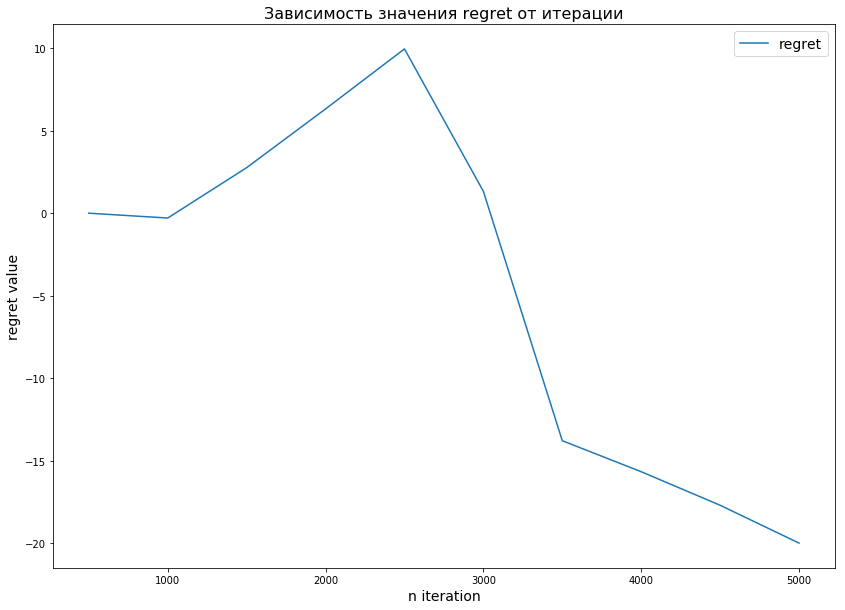

array([-1.30827116e-08, -2.91738001e-01,  2.76000922e+00,  6.32088166e+00,
        9.95808578e+00,  1.32423695e+00, -1.37896278e+01, -1.56685676e+01,
       -1.77013468e+01, -1.99951736e+01])

In [251]:
plot_regrets_every_500(stoch_OGD(np.zeros(d), len(spam_data), regrets=None, S=10))

accuracy: 0.39404477287546186


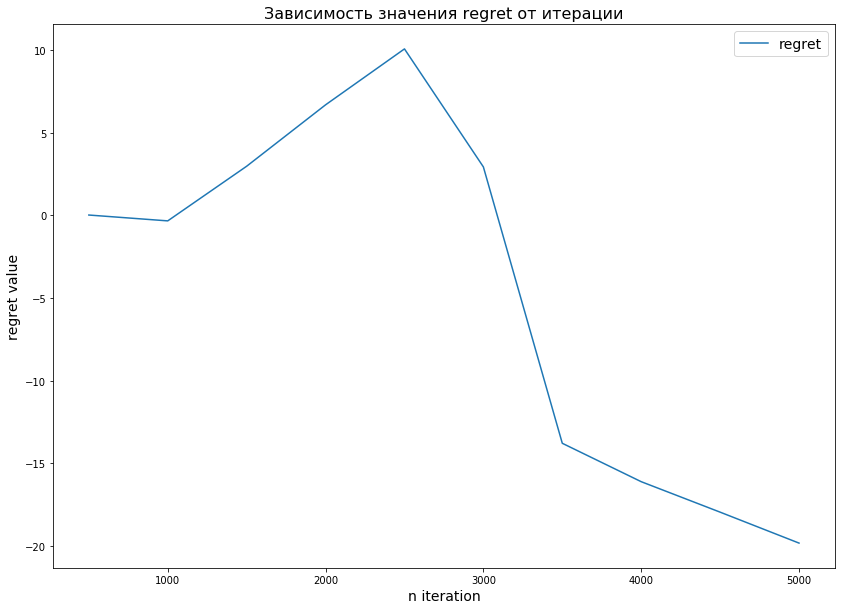

array([ 1.81855299e-02, -3.35446251e-01,  2.96943431e+00,  6.68399045e+00,
        1.00669508e+01,  2.92834719e+00, -1.37892680e+01, -1.61117564e+01,
       -1.79545226e+01, -1.98265649e+01])

In [252]:
plot_regrets_every_500(stoch_OGD(np.ones(d) * R / (float(d)**0.5), len(spam_data), regrets=None, S=10))

accuracy: 0.3946968050423821


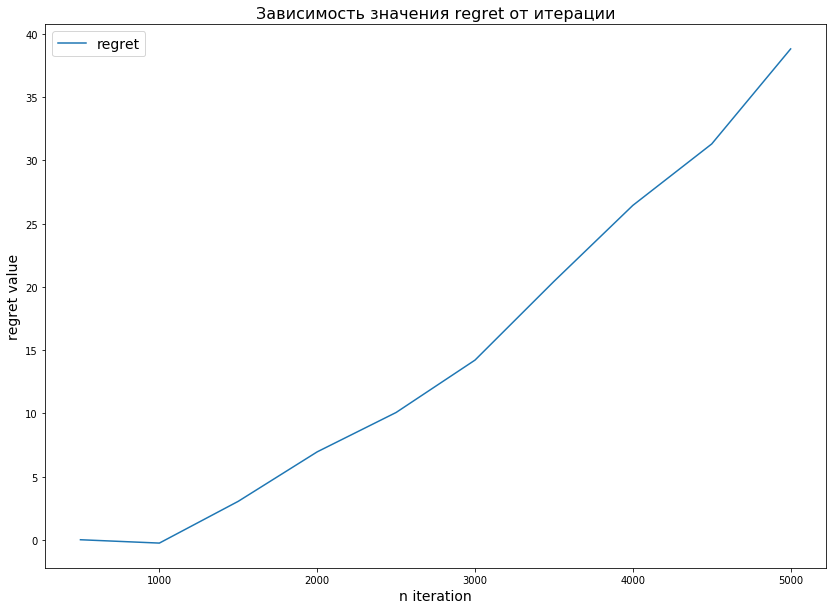

array([ 4.02800108e-03, -2.61025336e-01,  3.04316114e+00,  6.95241126e+00,
        1.00649278e+01,  1.42069699e+01,  2.04269578e+01,  2.64382670e+01,
        3.12986198e+01,  3.88113726e+01])

In [253]:
plot_regrets_every_500(stoch_OGD(np.hstack(([R], np.zeros(d - 1))), len(spam_data), regrets=None, S=10))

### Online Newton Step

Для начала научимся решать задачу методом проекций градиента. Воспользуемся уже написанной функцией поиска проекции на шар.

In [215]:
def isPSD(A, tol=1e-8):
    E,V = scp.linalg.eigh(A)
    return np.all(E > -tol)

In [257]:
def calc_armijo_step(f, gradf, h, x):
    alpha = 1
    beta = 0.1
    rho = 0.9
    while (f(proection(x - alpha * h)) >= f(x) + beta * alpha * np.array(gradf(x)).dot(h)):
        alpha *= rho
    return alpha

def matr_dist(A, x, y):
    return (x - y).T.dot(A.dot(x - y))

def matr_dist_grad(A, x, y):
    return 2 * A.dot(x - y)

#Решим задачу минимизации, выбирая шаг априорной последовательностью
def find_A_proection(A, y, tol=1e-3, max_iter=10000):
    it = 0
    x = proection(y)
    while it < max_iter:
        gradient = matr_dist_grad(A, x, y)
        #alpha = calc_armijo_step(lambda x: matr_dist(A, x, y),
        #                         lambda x: matr_dist_grad(A, x, y), gradient, x)
        alpha = 2. / (2. + np.sqrt(it))
        x_prev = x.copy()
        x = proection(x - alpha * gradient)
        if np.linalg.norm(x - x_prev) < tol:
            break
        it += 1
    return x

def find_A_proj_cvxpy(A, y):
    x = cvx.Variable(y.size)
    y_c = cvx.Constant(y)
    prob = cvx.Problem(cvx.Minimize(cvx.quad_form(x - y, A)), 
                       [cvx.norm(x) <= R])
    result = prob.solve(solver=cvx.SCS, verbose=False, eps=1e-5)
    if x.value is None:
        return find_A_proection(A, y)
    return x.value

alpha = 1 / 2
gamma = 1/2 * np.min([1./4./G/D, alpha])
epsilon = 1 / gamma**2 / D**2

def const_step():
    return 1. / gamma

def find_ons_solutions(x0, T, var_epsilon=epsilon, \
                       var_gamma=gamma, proj_solver='proj_grad'):
    x = x0
    A = var_epsilon * np.eye(d)
    A_rev = 1 / var_epsilon * np.eye(d)
    x_list = []
    for t in tqdm_notebook(range(T)):
        x_list.append(x)
        grad_val = grad(x, X[t], y[t])
        grad_col = grad_val.reshape(-1, 1)
        A = A + grad_col.dot(grad_col.T)
        A_revx = A_rev.dot(grad_val)
        A_revx_col = A_revx.reshape(-1, 1)
        A_rev = A_rev - A_revx_col.dot(A_revx_col.T)/(1 + grad_val.T.dot(A_revx))
        non_proj = x - 1. / var_gamma * A_rev.dot(grad_val)
        if proj_solver == 'proj_grad':
            x = find_A_proection(A, non_proj, tol=1e-7)
        else:
            x = find_A_proj_cvxpy(A, non_proj)
    return x_list

In [256]:
x0 = np.zeros(d)
x0[0] = R
sols = find_ons_solutions(x0, len(spam_data))

HBox(children=(IntProgress(value=0, max=4601), HTML(value='')))

In [282]:
def measure_accuracy(solutions):
    n_correct = 0
    for i in np.arange(len(solutions)):
        verdict = (np.sign(X[i].dot(solutions[i])) + 1) / 2
        if verdict == y[i]:
            n_correct += 1
    return n_correct * 1. / len(spam_data)

In [227]:
print('Accuracy: ', measure_accuracy(sols))

Accuracy:  0.647250597696153


Таким образом, видим, что этот метод даёт прогнозы менее точные, чем написанные ранее. Однако эти точности, близки, и, возможно, результаты сильно зависят от гиперпараметров.

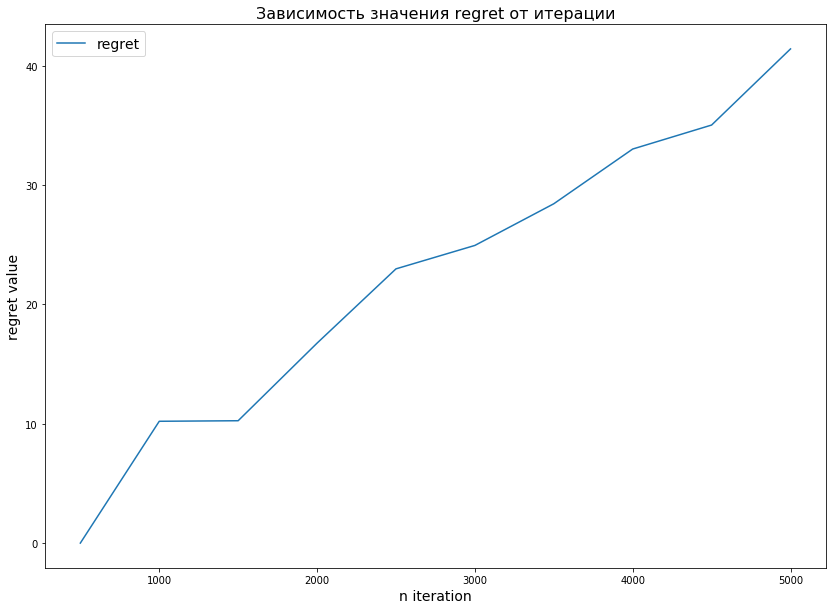

array([4.66832347e-03, 1.02071153e+01, 1.02530713e+01, 1.67520925e+01,
       2.29729672e+01, 2.49350824e+01, 2.84251721e+01, 3.30091386e+01,
       3.50187311e+01, 4.13949727e+01])

In [254]:
plot_regrets_every_500(sols)

Видим, что в плане $regret$ результаты похожи на градиентный спуск (около 40 на последней итерации). Видимо, на данном этапе константа ещё слишком велика, а размер данных наоборот велик недостаточно, чтобы почувствовать разницу между оценками сверху.

Одним из важных параметров является радиус шара, из которого будет выбираться начальное решение. Построим виджет, который позволит выбирать его, границу норм градиента $G$, префикс, на котором будут вычисляться ответы, а также метод поиска проекции на множество: искать его с помощью метода проекций градиента или же с использованием `cvxpy`

In [283]:
def make_interactive_ons(rad, g, n_iter, proj_solver):
    global M
    global R
    R = rad
    var_d = 2 * rad
    var_gamma = 1/2 * np.min([1./4./g/var_d, alpha])
    epsilon = 1 / var_gamma**2 / var_d**2
    M = 100. * rad
    x0 = np.zeros(d)
    x0[0] = rad
    int_sols = find_ons_solutions(x0, n_iter, epsilon, var_gamma, proj_solver)
    print('Accuracy: ', measure_accuracy(int_sols))

In [285]:
ons_widget = widgets.interactive(make_interactive_ons,
                 rad=widgets.FloatSlider(min=0.5, max=5, step=0.1, value=1.0),
                 g=widgets.FloatSlider(min=1, max=10, step=0.1, value=1.3),
                 n_iter=widgets.IntSlider(min=1, max=len(spam_data), step=1, value=30),
                 proj_solver=widgets.RadioButtons(options=['proj_grad', 'cvxpy'],
                     description='Projecton method', disabled=False))

display_widget(ons_widget)

HBox(children=(FloatSlider(value=1.0, description='rad', max=5.0, min=0.5), FloatSlider(value=1.3, description='g', max=10.0, min=1.0)))

HBox(children=(IntSlider(value=30, description='n_iter', max=4601, min=1), RadioButtons(description='Projecton method', options=('proj_grad', 'cvxpy'), value='proj_grad')))

HBox(children=(Output(),))

Output()

Видим, что поиск при помощи метода проекций градиента с априорным шагом оказывается быстрее. На 1000 итераций ещё и точнее, хотя для хорошей точности требуется большое количество примеров. На маленьких размерах можно посмотреть, как будет работать метод при изменении радиуса шара.

Также заметно, что при увеличении радиуса и $g$, метод проекций градиента работает ещё быстрее, при этом давая неплохую точность.